Este código es una simplificación del código completo, en el que sólo se usan los datos completos con el modelo de redes más simple.

Cargar librearias y datos

In [ ]:
# Librerias generales
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


# Libreria para el uso de archivos
from google.colab import drive

# Montar el disco de drive
drive.mount('/content/drive')


# -- Dónde está el directorio principal
project_folder = "/content/drive/My Drive/Colab Notebooks/"


# Declaramos las variables donde se guardan los datos
data = None
X    = None
Y    = None

# Hay que usar sensor.csv de 120MB
data_file      = "/datos/sensor.csv"             
                                                      

# Cárgamos el archivo en un dataframe
# NOTA: La columna para el sesonr 15 está vacía, esto es correcto
data = pd.read_csv( project_folder + data_file, sep = ",", header=0)
  
# Eliminamos las dos primeras columnas que son la fecha y el índice
data = data.drop(data.columns[[0]], axis=1) # axis = 1 significa columna
data = data.drop(data.columns[[0]], axis=1) 

# Cambiamos los estados de Y, que vienen como
#      {NORMAL, BROKEN, RECOVERING}
#      {1     , 0     , 0}
data['new'] = 1
for i in range(0,data.shape[0]):
  if ( (data.iat[i, data.shape[1]-2] ) != "NORMAL"):
    data.iat[i, data.shape[1]-1] = 0

# Borramos la columna de Y antigua
data = data.drop(data.columns[[  data.shape[1]-2  ]], axis=1) 

# Separammos los datos y definimos las matrices X e Y
X = data.iloc[:,0:data.shape[1]-1]
Y = data.iloc[:,data.shape[1]-1]

# No se eliminan ninguna de las columnas

# Guardamos las dimensiones de la matrix de entrada X para luego
totalInputsRows    = X.shape[0]
totalInputsColumns = X.shape[1]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Limpiar los datos (1m 28s)

In [ ]:
# --------------------------------------
# Limpiar NAs de las tablas
# --------------------------------------

# Hasta aquí los datos están listos para ser usados. Pero vamos a ver que pasa
# cuando limpiamos los datos bien, ya sea interpolando o quitando columnas y
# filas enteras

# Comprobamos el estado de salud de los datos
data.isna().sum()
# Esto nos dice que las columnas 15 y 50 son una patata, las quitamos
# directamente.
newData = data.copy()
del newData['sensor_15']
del newData['sensor_50']

# Buscamos fila por fila y quitamos las que tengan NAs
deleteTheseRows = [False]*newData.shape[0]
for i in range(0, newData.shape[0]):

  if (   newData.iloc[i,].isna().sum()  >= 1   ) :
    deleteTheseRows[i] = True

print("Total eliminadas ", sum(deleteTheseRows))

# newData tiene ahora mismo todos los datos originales sin filas NA
newData = newData.drop(newData[deleteTheseRows].index)


# Separammos los datos y definimos las matrices X e Y
X = newData.iloc[:,0:newData.shape[1]-1]
Y = newData.iloc[:,newData.shape[1]-1]

# Guardamos las dimensiones de la matrix de entrada X para luego
totalInputsRows    = X.shape[0]
totalInputsColumns = X.shape[1]


Total eliminadas  24505


Submuestra de datos.

Esta parte elige de forma aleatoria N muestras, da igual que sean Y = 0 o Y = 1

In [ ]:
# ------------------------------------------------------------------------------
# Limpiar los NA hace que el modelo funcione, vamos a probar submuestras ahora
# ------------------------------------------------------------------------------
newData2 = False
if(False):

  # Pick 1000 rows at random
  newData2 = newData.sample(n=10000)

else:

  newData2 = newData.copy()

# Separammos los datos y definimos las matrices X e Y
X = newData2.iloc[:,0:newData2.shape[1]-1]
Y = newData2.iloc[:,  newData2.shape[1]-1]

# Guardamos las dimensiones de la matrix de entrada X para luego
totalInputsRows    = X.shape[0]
totalInputsColumns = X.shape[1]



Balanceo de datos

Esta parte hace tres cosas:

- Limpia las filas que se parecen mucho (TODO)
- Elimina Y=1s hasta que se quede en proporción con Y=0s

En total, solamente hay 3046 filas completas con Y = 0.

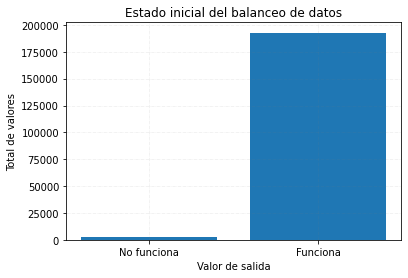

In [ ]:
# Comprobamos el estado de las Ys


# Podemos hacer:
#
#   DOWNSAMPLING - Quitar filas de 1s hasta tener los mismos 0s
#
#   UPSAMPLING   - Añadir filas de 0s hasta tener los mismos 1s


# Contamos las Y
salida_data = { 'No funciona':0 ,
                'Funciona':0}

salida_data['Funciona']    = sum(Y == 1)
salida_data['No funciona'] = sum(Y == 0)

 
# Hacer el barplot
# ---- Seleccionar datos
balanceoPlot = plt.bar(salida_data.keys(), salida_data.values())
# ---- Añadir las líneas horizontales
plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
# ---- Rótulos
plt.xlabel("Valor de salida")
plt.ylabel("Total de valores")
plt.title("Estado inicial del balanceo de datos")
plt.show()


In [ ]:
print(salida_data)

# Comprobamos que filas tienen 0s y cuales tienen 1s
trueRows  = [i for i, x in enumerate(Y) if x == 1]
falseRows = [i for i, x in enumerate(Y) if x == 0]

{'No funciona': 3046, 'Funciona': 192769}


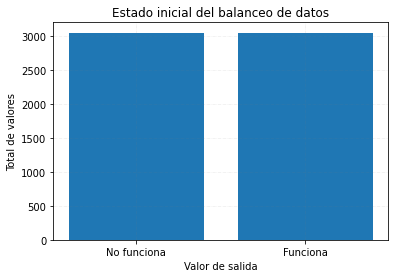

In [ ]:
# Comprobamos que filas tienen 0s y cuales tienen 1s
trueRows  = [i for i, x in enumerate(Y) if x == 1]
falseRows = [i for i, x in enumerate(Y) if x == 0]

# Elegimos la opción que queremos
balanceOption = "Downsampling"
#balanceOption = "Upsampling"

# Para la opción de eliminar datos con Y = 1
if balanceOption == "Downsampling":

  # /!\ Hablamos de elegir datos de forma aleatoria, o elegir datos que estén en las X anteriores filas de Y = 0 ? <------------------------------

  # Elegimos las filas con 1s de forma aleatoria
  finalRows = random.choices(trueRows, k = salida_data['No funciona'])

  # Añadimos las filas que tienen 0s
  finalRows = finalRows + falseRows
  finalRows.sort()
  
  # Guardamos de nuevo esto en otro conjunto de datos para luego
  balancedNoNAData = newData2.copy()
  balancedNoNAData = newData2.iloc[ finalRows  , ]

  # Eliminamos el resto del conjunto de datos
  # Separammos los datos y definimos las matrices X e Y
  X = newData2.iloc[ finalRows  , 0:newData2.shape[1]-1 ]
  Y = newData2.iloc[ finalRows  ,   newData2.shape[1]-1 ]

  # Guardamos las dimensiones de la matrix de entrada X para luego
  totalInputsRows    = X.shape[0]
  totalInputsColumns = X.shape[1]

# Contamos las Y
salida_data = { 'No funciona':0 ,
                'Funciona':0}

salida_data['Funciona']    = sum(Y == 1)
salida_data['No funciona'] = totalInputsRows - salida_data['Funciona']

 
# Hacer el barplot
# ---- Seleccionar datos
balanceoPlot = plt.bar(salida_data.keys(), salida_data.values())
# ---- Añadir las líneas horizontales
plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
# ---- Rótulos
plt.xlabel("Valor de salida")
plt.ylabel("Total de valores")
plt.title("Estado inicial del balanceo de datos")
plt.show()


Ignorar esto, es solamente para ver si los datos están bien

In [ ]:
print(sum(deleteTheseRows))

print(newData.shape[0])
print(newData.shape[1])

print(totalInputsRows)
print(totalInputsColumns)

X.head()

24505
195815
51
6092
50


,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51
41,2.453588,49.26215,53.124996,46.180550,637.9630,73.73936,13.25231,16.16753,15.37182,15.11863,...,30.989582,32.291664,39.06250,36.458332,45.13889,43.11343,38.194440,234.0856,77.83565,219.9074
78,2.449653,47.48264,53.168400,45.963540,627.5463,71.57556,13.52720,16.12413,15.65393,15.08247,...,33.072910,32.552082,40.88541,40.219910,48.90046,41.08796,38.773148,164.9306,65.68287,199.3634
81,2.445718,47.26563,53.038190,45.876740,644.7916,75.33871,13.59954,16.13136,15.76968,15.11863,...,32.552080,32.552080,39.32291,40.798610,46.87500,42.24537,39.062500,168.9815,73.49537,189.5255
97,2.451620,48.17708,53.125000,45.963540,639.4676,74.36434,13.56337,16.16030,15.77691,15.16204,...,32.812500,35.416660,37.76041,46.296300,46.29630,46.29630,39.641200,176.7940,65.10416,187.2106
100,2.464410,48.26389,53.124996,45.963539,637.7314,73.44002,13.61400,16.16753,15.45139,15.11863,...,31.770830,34.114582,40.36458,47.453700,48.90046,44.84954,40.219910,195.0231,67.99769,193.8657


Dividir en datos de entrenamiento y datos de evaluación

Hacer esta división varias veces para justificar que no haya sido suerte.

In [ ]:
# Divide los datos que te quedan en Entrenamiento y Evaluación  
balancedNoNADataTrain = balancedNoNAData.sample(frac = 0.8)
balancedNoNADataTest  = balancedNoNAData.drop(balancedNoNADataTrain.index)

# Crea los diferentes X e Y
Xtrain = balancedNoNADataTrain.iloc[  :  , 0:newData2.shape[1]-1 ]
Xtest  = balancedNoNADataTest.iloc[   :  , 0:newData2.shape[1]-1 ]

Ytrain = balancedNoNADataTrain.iloc[  :  ,   newData2.shape[1]-1 ]
Ytest  = balancedNoNADataTest.iloc[   :  ,   newData2.shape[1]-1 ]

# Guardamos las dimensiones de la matrix de entrada X para luego
totalInputsRows    = Xtrain.shape[0]
totalInputsColumns = Xtrain.shape[1]

Tests

In [ ]:
print(Xtrain.shape[0])
print(Xtrain.shape[1])

print(totalInputsRows)
print(totalInputsColumns)

Xtrain.head()

4874
50
4874
50


,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51
111540,2.500810,49.001736,51.041660,43.402775,631.713000,77.40170,13.744210,15.58160,14.96672,15.08247,...,37.760410,37.500000,44.01041,38.773150,37.615742,44.560180,43.692130,76.388890,52.372684,207.175900
78119,0.003935,47.309020,47.916664,44.270830,259.901596,0.00000,9.006076,11.39323,11.36429,11.55237,...,91.666660,47.916660,47.13541,32.986111,31.539350,31.539352,37.326390,36.168980,49.479170,33.275463
154249,2.500810,43.880210,50.086800,44.791664,633.680500,77.14965,14.156540,16.47135,15.69734,15.08247,...,30.989582,31.510420,41.92708,32.986111,33.854170,40.219910,37.326390,131.944400,43.113430,158.275500
70573,0.112153,42.404510,44.314240,38.368050,471.429382,0.00000,11.357060,10.05498,10.04774,10.14178,...,27.864580,29.166666,54.94791,29.224537,31.539350,60.474540,32.407406,30.671297,30.092590,30.960650
686,2.466377,46.744790,52.517360,45.442707,634.030600,75.95602,13.353590,16.16030,15.73351,15.11863,...,34.114582,35.416664,43.22916,53.819440,55.266200,42.245370,41.956020,199.652800,88.252310,206.886600


Definir modelo

In [ ]:

# Definir cuantras entradas tiene el modelo
myInputShape     = (totalInputsColumns,)

# Módelo A, una red con dos capas intermedias 10 x 10 con función LOSS

# Para el modelo A, definimos las siguientes capas ocultas:
modeloA_ocultaA = tf.keras.layers.Dense(units = 10, input_shape = myInputShape, activation = 'relu')
modeloA_ocultaB = tf.keras.layers.Dense(units = 10, activation = 'relu')
modeloA_salida  = tf.keras.layers.Dense(units = 1,  activation = 'sigmoid')

# Creamos cada uno de los modelos
modeloA = tf.keras.Sequential([modeloA_ocultaA, modeloA_ocultaB, modeloA_salida])

# Compilamos cada uno de los modelos
modeloA.compile( optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy' )

Entrenar el modelo

Tarda 1h 42m con todas las columnas y todos los datos que no son NA. Da unos resultados muy buenos, que puede ser porque hay una desproporción de Y=1.ç

Tarda 2m 23s con 3000 muestras de cada grupo (Y=0, Y=1), que son lo máximo Y=0 que hay no siendo NA en ninguna de las columnas de X. Y también da un resultado bueno.

Comenzando a entrenar...
    Modelo A...
Entrenamiento concluido


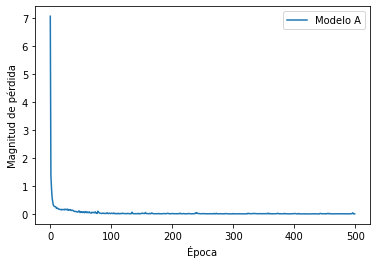

In [ ]:
# Ponemos la misma semilla para que salgan los mismos resultados en cada ejecución
#np.random.seed(9999)

# Entrenamos el modelo
# - Las epocas es cuantas vueltas da el modelo
# - El lote es cuantas muestras de Y usamos para entrenar el modelo cada vez
epocas = 500
lote   = 64
print("Comenzando a entrenar...")

# Modelo A
print("    Modelo A...")
historialA = modeloA.fit(Xtrain, Ytrain, epochs = epocas, batch_size = lote, verbose = False)

# Pintamos la función LOSS con respecto a las épocas
plt.xlabel("Época")
plt.ylabel("Magnitud de pérdida")
plt.plot(historialA.history["loss"], label='Modelo A')

# Cuando termine el entrenamiento (unos 50s) comunicamos que está terminado
print("Entrenamiento concluido")

# Pintamos la leyenda para cada modelo y mostramos el gráfico
leg = plt.legend()
plt.show()

Evaluación del modelo

Modelo A: 
0.011669833213090897
0.9977431297302246


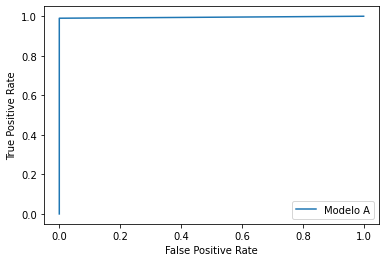

In [ ]:
# Evaluamos el modelo y mostramos LOSS y precisión
#accuracy_A = modeloA.evaluate(X,    Y,    verbose = False)

print("Modelo A: ")
print(historialA.history["loss"][epocas-1])
print(historialA.history['accuracy'][epocas-1])


# Evaluamos el modelo mostrando las curvas ROC para cada uno
modeloA_prediccion = (modeloA.predict(Xtest,    verbose = False) > 0.5).astype(int)

fprA , tprA , thresholdsA = roc_curve(Ytest    , modeloA_prediccion)

# Pintamos el gráfico
plt.plot(fprA, tprA, label = 'Modelo A') 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 

leg = plt.legend()

plt.show()  

Ejemplo de predicciones

In [ ]:
# Hacemos predicciones con el modelo A
predicciones = (modeloA.predict(Xtest) > 0.5).astype(int)

# Mostramos por pantalla a ver si lo hace bien
for i in range(5):
    print("------------------")
    print()
    print("    Predicción "+str(i))
    print("        Los datos:")
    print((X.iloc[[i]]))
    print("        Deberían salir:")
    print((Y.iloc[i]))
    print("        El módelo dice:")
    print(predicciones[i][0])
    print()

38/38 [==============================] - 0s 3ms/step
------------------

    Predicción 0
        Los datos:
    sensor_00  sensor_01  sensor_02  sensor_03  sensor_04  sensor_05  \
41   2.453588   49.26215  53.124996   46.18055    637.963   73.73936   

    sensor_06  sensor_07  sensor_08  sensor_09  ...  sensor_41  sensor_42  \
41   13.25231   16.16753   15.37182   15.11863  ...  30.989582  32.291664   

    sensor_43  sensor_44  sensor_45  sensor_46  sensor_47  sensor_48  \
41    39.0625  36.458332   45.13889   43.11343   38.19444   234.0856   

    sensor_49  sensor_51  
41   77.83565   219.9074  

[1 rows x 50 columns]
        Deberían salir:
1
        El módelo dice:
1

------------------

    Predicción 1
        Los datos:
    sensor_00  sensor_01  sensor_02  sensor_03  sensor_04  sensor_05  \
78   2.449653   47.48264    53.1684   45.96354   627.5463   71.57556   

    sensor_06  sensor_07  sensor_08  sensor_09  ...  sensor_41  sensor_42  \
78    13.5272   16.12413   15.65393   


Función de pesos

In [ ]:

print("----------------------")
print("Modelo A: ")
print()
print("    Primera capa:")
print()
print(modeloA_ocultaA.get_weights())
print()
print("    Segunda capa:")
print()
print(modeloA_ocultaB.get_weights())
print()
print("    Salida:")
print()
print(modeloA_salida.get_weights())

----------------------
Modelo A: 

    Primera capa:

[array([[-2.75207591e+00, -1.18609083e+00,  1.48787588e-01,
         1.31232888e-01,  1.35172665e-01, -1.33824617e-01,
         2.14943096e-01,  5.20596921e-01,  9.72074926e-01,
         1.88321853e+00],
       [-3.86008710e-01,  3.78663652e-02,  2.36857563e-01,
        -6.04604222e-02,  2.78073281e-01,  1.42621964e-01,
         1.53961293e-02, -3.46221566e-01,  3.30334127e-01,
         3.66135865e-01],
       [-2.85089046e-01, -2.65414685e-01,  7.74618983e-03,
         1.41147152e-01, -1.11638561e-01, -6.80655241e-03,
        -2.54367173e-01, -3.19831401e-01, -7.14512989e-02,
         4.88293096e-02],
       [ 4.37797373e-03, -2.05170847e-02, -3.92179191e-02,
         8.28920156e-02,  7.12230802e-03, -2.55454242e-01,
        -1.49181798e-01, -1.50744677e-01,  1.29628167e-01,
        -1.25199810e-01],
       [-2.17636023e-02, -3.08830142e-01, -1.59441963e-01,
         2.76731402e-01,  1.24760538e-01, -4.34248745e-02,
        -4.9597

Se podría probar ahora dividiendo en 70/30 para conjunto de entrenamiento y conjunto de prueba, si consideramos que 3000 Y=0 son suficientes